Candidate numbers:
112, 267, 168, 237

# Group Exam INFO 284

## Importing libraries

The following imports are requiered

In [2]:
# Standard libraries
import ast
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Machine Learning - Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    median_absolute_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# Machine Learning - XGBoost
import xgboost as xgb

# Deep Learning - TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sindr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1: Sentiment Analysis

### Fetching data

In [3]:
data=pd.read_csv('Hotel_Reviews.csv') #read the csv file

### Data analysis

This is the data analysis part. We have decided to split the reviews beetween positive and negative review. Any review score greater or equal to 5, we classify as a positive review, and the rest as negative review. Our goal is to try to find what data points have little correlation on whether the review score is positive or negative. Currently we have not used the result of this analysis yet, but it will be used in our final draft. 

In [ ]:
# Preparing data for analysis
# This cell is a bit slow to run, so it is intended to be run only once

# The next part of the code aims to split the 'Tags' column into multiple columns

data['Tags'] = data['Tags'].apply(ast.literal_eval) # Convert the string to a list, This code is made by chatgpt

# The following 3 lines of code is made by github copilot

tags_expanded = data['Tags'].apply(pd.Series) # Expand the 'Tags' column into multiple columns

tags_expanded.columns = [f'Tag_{i}' for i in range(tags_expanded.shape[1])] # Rename the columns for better readability

data = pd.concat([data, tags_expanded], axis=1) # Concatenate the expanded tags with the original dataframe

data.drop('Tags',axis=1,inplace=True)   # Drop the column 'Tags' due to the data being split into multiple columns

# The next part of the code turns the 'days_since_review' and 'Tag_3' columns into integers
data['days_since_review']=data['days_since_review'].str.extract('(\d+)').astype(int) # Extract the number from the string. This code if made using chatgpt
data['Tag_3'] = data['Tag_3'].str.extract('(\d+)').astype(float) # Extract the number from the string and convert to float. For some reason it did not work as int

# Label encode non-numerical features

label_encoded_hotel_address = LabelEncoder()
data['Hotel_Address'] = label_encoded_hotel_address.fit_transform(data['Hotel_Address'])

label_encoded_hotel_name = LabelEncoder()
data['Hotel_Name'] = label_encoded_hotel_address.fit_transform(data['Hotel_Name'])

label_encoded_reviwer_nationality = LabelEncoder()
data['Reviewer_Nationality'] = label_encoded_reviwer_nationality.fit_transform(data['Reviewer_Nationality'])

# # The next part of the code creates a new dataframe with hotel names and removes it from the dataframe data
# hotel_names = data['Hotel_Name'] # Create a new dataframe with the hotel names
# data.drop('Hotel_Name',axis=1,inplace=True) # Drop the column 'Hotel_Name' as it is not needed in the model

#### Plot of correlation matrix in order to see which numerical features can be dropped.

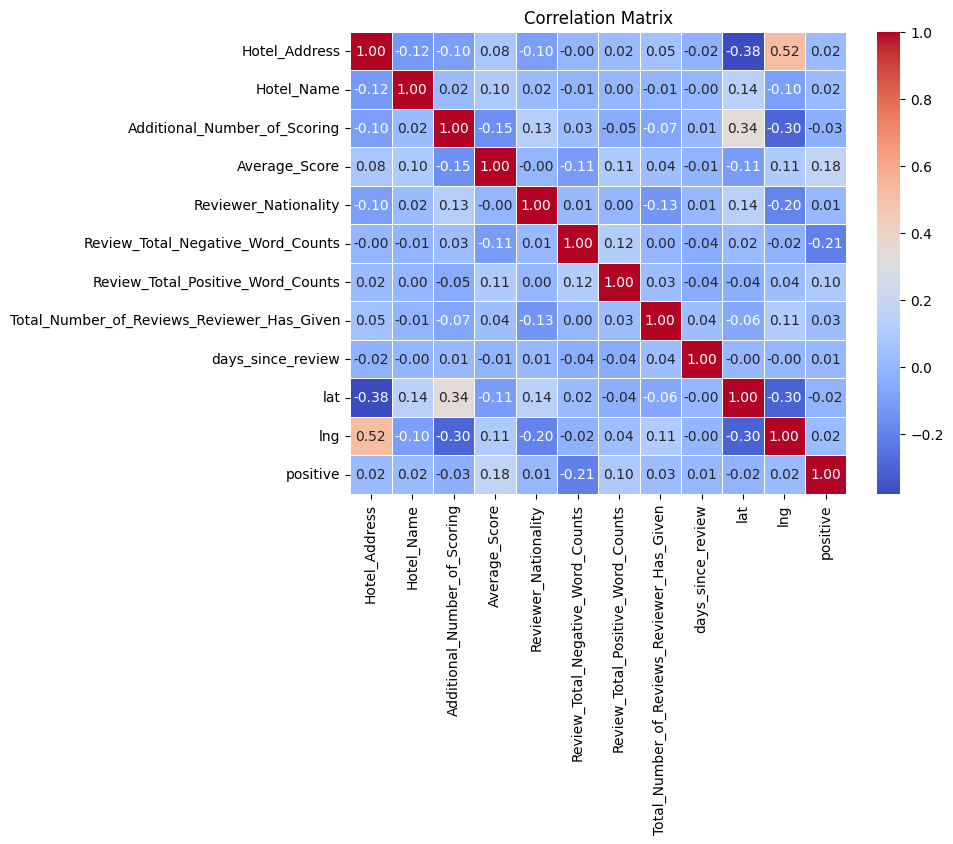

In [5]:
# binary variable to determine sentiment (1 if Reviewer_Score >= 5, else 0)
data['positive'] = (data['Reviewer_Score'] >= 5).astype(int)

numerical_data = data[['Hotel_Address', 'Hotel_Name','Additional_Number_of_Scoring', 'Average_Score', 'Reviewer_Nationality', 'Review_Total_Negative_Word_Counts',
                            'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given',
                            'days_since_review', 'lat', 'lng', 'positive']]

# Compute correlation matrix
correlation_matrix = numerical_data.corr()

# Visualize the correlation matrix using a heatmap (ChatGPT)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

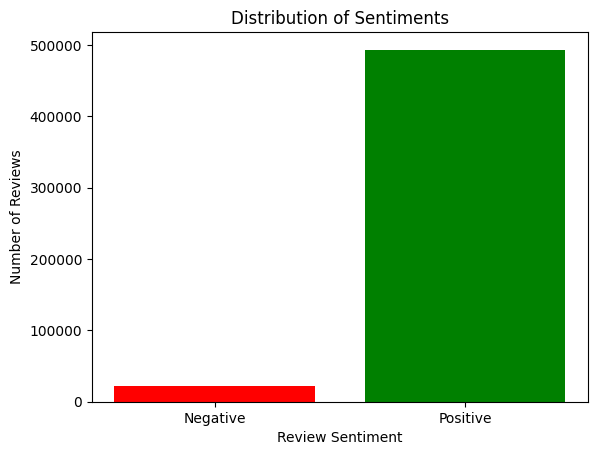

Counter({1: 493457, 0: 22281})


In [6]:
# Used for plotting the amount of positive and negative reviews

# convert reviewer score to binary labels (positive or negative review)
sentiment = (data['Reviewer_Score'] >= 5).astype(int)

positive_count = np.sum(sentiment == 1)
negative_count = np.sum(sentiment == 0)

categories = ['Negative', 'Positive']
counts = [negative_count, positive_count]

plt.bar(categories, counts, color=['red', 'green'])
plt.xlabel("Review Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Sentiments")

plt.show()
print(Counter(data['positive'])) # finding ratio of positive to negative reviews

Dealing with the imbalance
The issue
When setting the threshold at 5, we get an extremely umbalanced target variable. ~95% of reviews have a reviewer score of 5 or higher. This means that the models can achieve 95% accuracy by guessing that every review is positive.

Methods
There are multiple ways of dealing with imbalance. The most common methods are

Resampling (over/undersampling)
Oversampling: Include more of the minority class
Might cause overfitting
Undersampling: Include less of the majority class
Lower risk of overfitting, but information is lost
Class weights
Assign a weight to the classes that punishes predicting negative reviews as positive
Good for binary classification
Focal loss
Focuses learning on the minority class
Stratification
Ensures the ratio of positive and negative reviews remains constant when splitting the dataset

### Basic data cleaning

This is the basic data cleaning that should be the base part in each of the four models. Each model will do more data cleaning depending on whats relevant for their specific model.

We drop any feature that has a near-zero correlation with sentiment. Additionally, we assume that Review_Date has no correlation with sentiment.

We drop hotel identifiers because we want our models to generalize better

In [66]:
# Dropping irrelevant features
data.drop('Hotel_Address',axis=1,inplace=True)  
data.drop('Hotel_Name',axis=1,inplace=True)  
data.drop('Review_Date',axis=1,inplace=True)    
data.drop('Additional_Number_of_Scoring',axis=1,inplace=True)  
data.drop('lat',axis=1,inplace=True)    
data.drop('lng',axis=1,inplace=True)    
data.drop('Total_Number_of_Reviews',axis=1,inplace=True)   
data.drop('Total_Number_of_Reviews_Reviewer_Has_Given',axis=1,inplace=True)
data.drop('days_since_review',axis=1,inplace=True)  
data.drop('Reviewer_Nationality',axis=1,inplace=True)  

### Model 1 XGB-Regressor

This is a model using a model from XGBoost(Extreme Gradient Boosting). This is a boosted decision tree. This model aims to try to predict the review-score without directly predicting the sentiment in the texts in positve and negative review. 

A boosted decision tree works by creating several consecutive decision trees, where the following trees are aimed to correct the errors of the earlier trees. These trees are often shallow compared to what would be common if there was a single decision tree. One big advantage of this compared to normal decision trees, is that it reduces the risk of overfitting. 

In [67]:
xgb_data = data.copy() # Create a copy of the dataframe data
xgb_data.drop('Negative_Review',axis=1,inplace=True) # Drop the column 'Negative_Review' as it is not a numeric value
xgb_data.drop('Positive_Review',axis=1,inplace=True) # Drop the column 'Positive_Review' as it is not a numeric value

# One hot encode only the necessary columns
# xgb_data = pd.get_dummies(xgb_data, columns=['Tag_0', 'Tag_1', 'Tag_2', 'Tag_4', 'Tag_5'], dtype=int)

tags = ['Tag_0', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5']

for tag in tags:
    label_encoded_tags = LabelEncoder()
    xgb_data[tag] = label_encoded_tags.fit_transform(xgb_data[tag])

# Turn the 'Reviewer_Score' column into a scale from 0-100 instead of 0-10
xgb_data['Reviewer_Score'] = xgb_data['Reviewer_Score'] * 10
xgb_data['Reviewer_Score']=xgb_data['Reviewer_Score'].astype(int) # Convert the 'Reviewer_Score' column to int

In [68]:
# The next part of the code splits the data into training and testing data. 
x = xgb_data.drop('Reviewer_Score',axis=1) # Define the features
y = xgb_data['Reviewer_Score'] # Define the target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=69, stratify=y) # Split the data into training and testing data. Stratify=y is to make sure the data is split in the same ratio as the original data. This is important due to the imbalanced data.

Due to the inbalance of this dataset, I have implemented sample weights in order to prevent this model from prediction mostly positive reviews. This will give this model a greater error rate.

In [69]:
# Create sample weights for the training data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [70]:
xgb_model = xgb.XGBRegressor(tree_method='hist')
xgb_model.fit(x_train, y_train, sample_weight=sample_weights) # Fit the model to the training data

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [71]:
guess=xgb_model.predict(x_test) # Make a guess on the testing data

In [72]:
mse=mean_squared_error(y_test,guess) # Calculate the mean squared error
print(mse)

278.79730895593013


In [73]:
mae=mean_absolute_error(y_test,guess) # Calculate the mean absolute error
print(mae)

13.462672702495146


In [74]:
r2=r2_score(y_test,guess) # Calculate the r2 score
print(r2)

-0.03941357135772705


In [75]:
mape=mean_absolute_percentage_error(y_test,guess) # Calculate the mean absolute percentage error
print(mape)

0.16824126171241616


In [76]:
medianae=median_absolute_error(y_test,guess) # Calculate the median absolute error
print(medianae)

11.625740051269531


<Axes: xlabel='Reviewer_Score'>

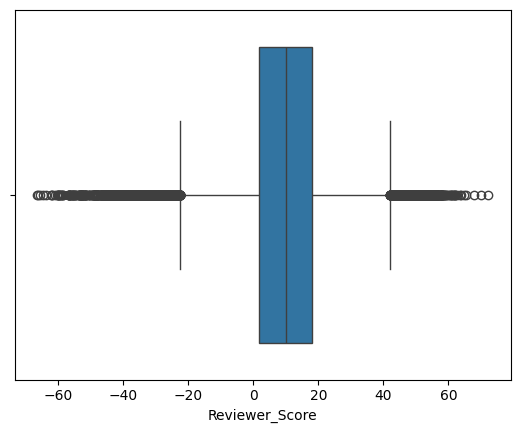

In [77]:
sns.boxplot(x=y_test-guess) # Create a boxplot of the data

In [79]:
count = 0 
for i in guess:
    if i < 50: 
        count += 1
print(f'Amount of reviews with a predicted score of less than 5: {count}')

Amount of reviews with a predicted score of less than 5: 5911


In [80]:
print(min(guess)) 

13.575004


By looking at the different evaluation metrics, we can see that this model is not overly accurate in its prediction. These scores will improve quite significantly if we were too remove the sample weights, but then we get very few negative reviews. Without the sample weights, it predict more than 10 times fewer reviews below 5.0 than with the sample weights. The minimum review-score guessed is also significantly higher. This shows that the model would bee overfitted to positive reviews if sample weights where not used.

It would be possible to improve the different error scores by parameter tuning, but when I tried using GridSearch, it ran for over 6 hours before the kernel crashed. The model therefore uses the default parameters.

### Model 2 KNN


#### How the model works
This model is based on supervised learning: multiple data points with a related target value (vector y) are observed. Then, the model learns how to recognize new input (x) and predict its output(y) based on other similar data points (closest neighbors). 
The k-nearest neighbors-method will perform well for this dataset; It is a simple algorithm to implement, easy to adapt to new training samples, and well suited for this data size. For bigger data size, KNN would not be optimal and work too slow. The data is low-dimensional space( < 100 ), which makes KNN perfect for this task. The low dimensional space is making it possible to calculate the distance between the data points because the closest neighbors actual are similar and not irrelevant.

#### Data
The dataset "Hotel_Reviews" has over 500 000 data points which is a good foundation for model model training. It is both values and text, so we need to have to pre-preocess this so the model can calculate our prediction. 

In this case, we chose to predict output y based on the 707 nearest neighbors. Choosing the number of neighbors k is important but challenging, as there is many correct answers.

A small k result in a low bias and high variance (the model adapts instantly to noise)
a large k result in high bias ans low variance (the model predicts values close to the mean)

The goal is to find a value of k that is the perfect balance between bias and variance, and gives the best performance.
Since this dataset contains over 500 000 data points, it is important to choose a k that is large enough to concider enough callues when predicting y, but not so large that the model loses precision. 

Often, it is conveniant to set k = sqrt(n), wherre n is the number of data points. This gives k = 707 in our case. We have also experimented with other values of k to find the perfect value to be used.

#### Measures to deal with imbalanced target variable

For this model we wanted to see what happens when no measures are taken to deal with the imbalanced dataset. This will give us a better understanding of the consequences of an imbalanced dataset.

In [12]:
data.fillna(0, inplace=True)  # Replace Nan-values with 0

In [16]:
knn_data = data.copy()

knn_data.drop(['Negative_Review', 'Positive_Review'], axis=1, inplace=True) # In this model, these categories can not be used because the length of words that can not be converted to dummies.


# Label encode non-numerical features. LabelEncoder is neccesary for the Kernel to not crash due to data overload. This will happend when too many unique values are created when converting categorical values to continous values.
label_encoded_tag_0 = LabelEncoder()
knn_data['Tag_0'] = label_encoded_tag_0.fit_transform(knn_data['Tag_0'].astype(str))

label_encoded_tag_1 = LabelEncoder()
knn_data['Tag_1'] = label_encoded_tag_1.fit_transform(knn_data['Tag_1'].astype(str))

label_encoded_tag_2 = LabelEncoder()
knn_data['Tag_2'] = label_encoded_tag_2.fit_transform(knn_data['Tag_2'].astype(str))

label_encoded_tag_3 = LabelEncoder()
knn_data['Tag_3'] = label_encoded_tag_3.fit_transform(knn_data['Tag_3'].astype(str))

label_encoded_tag_4 = LabelEncoder()
knn_data['Tag_4'] = label_encoded_tag_4.fit_transform(knn_data['Tag_4'].astype(str))

label_encoded_tag_5 = LabelEncoder()
knn_data['Tag_5'] = label_encoded_tag_5.fit_transform(knn_data['Tag_5'].astype(str))

print(knn_data.head())

   Average_Score  Review_Total_Negative_Word_Counts  \
0            7.7                                397   
1            7.7                                  0   
2            7.7                                 42   
3            7.7                                210   
4            7.7                                140   

   Review_Total_Positive_Word_Counts  Reviewer_Score  Tag_0  Tag_1  Tag_2  \
0                                 11             2.9      5    132    685   
1                                105             7.5      5    132    685   
2                                 21             7.1      5    442    685   
3                                 26             3.8      5    715    685   
4                                  8             6.7      5    132   1879   

   Tag_3  Tag_4  Tag_5  
0     27     15      1  
1     25     15      1  
2     22     14      1  
3     22     15      1  
4     11     14      1  


I chose to remove the categories "Negative_Review" and "Positive Review" because they are a string of text and therefore useless for this model. Removing these categories from the data set, makes the model running faster and easier to work with. 

LabelEncoder is used to convert the categorical data to numbers.

In [17]:
features = knn_data.columns
scaler = MinMaxScaler()                                          
knn_data[features] = scaler.fit_transform(knn_data[features])  # Scale the columns from 0-1


X = knn_data.drop('Reviewer_Score', axis=1)     #Need to drop this column so the predited output is not the actual input
y = knn_data['Reviewer_Score'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=68) # Split the data in to train/test-set

knn = KNeighborsRegressor(n_neighbors=707)        # Use regression because the values are continuous
knn.fit(X_train, y_train)                                  

y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)    #Distance from predicted value to actual value

print(f'Mean square error: {mse:.4f}')

Mean square error: 0.0337


Scaling is important so all the values are equally weighted. Since this model is based on distance to the neightbors, we would have an incorrect result if not.

The distance from predicted value to actual value is our mean squared error, and is used to measure accuracy of the model. Our model has a mse of 0.0384, which means that the model is suited for predicting data. 

The values in our dataset are continuous and not categorical. A suitable choice would be to use Euclidian-distance. This is also the standard used in scikit-lear library, which we chose to use.

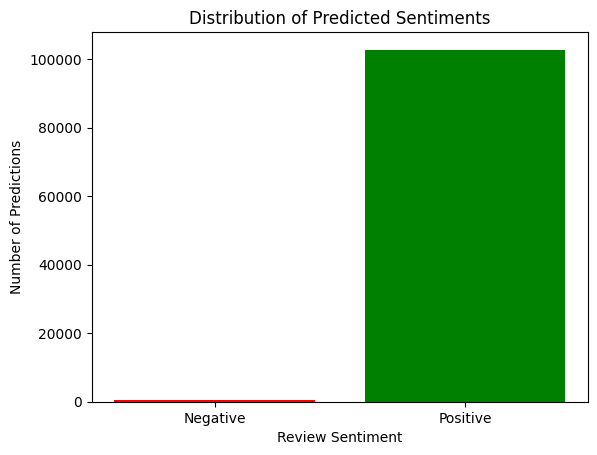

[np.int64(451), np.int64(102697)]


In [20]:
positive_count = np.sum(y_pred >= 0.5)
negative_count = np.sum(y_pred < 0.5)

categories = ['Negative', 'Positive']
counts = [negative_count, positive_count]

plt.bar(categories, counts, color=['red', 'green'])
plt.xlabel("Review Sentiment")
plt.ylabel("Number of Predictions")
plt.title("Distribution of Predicted Sentiments")

plt.show()
print(counts)

<Axes: xlabel='Reviewer_Score'>

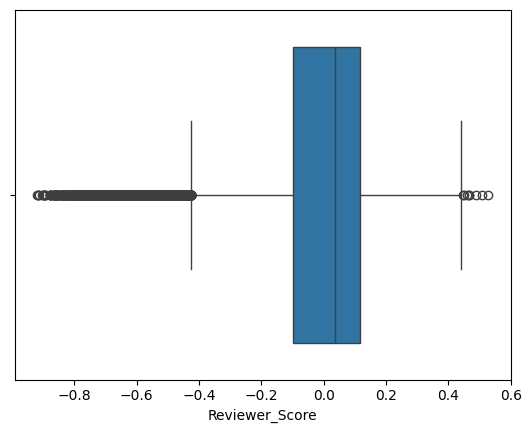

In [21]:
sns.boxplot(x=y_test-y_pred)

Our model overestimates the prediction by constantly guessing high rating. This is because the large number of positive reviews. By doing this, our model get a low MSE, but a high false positive rate. One solution to handle this unbalance is to weigh the nearest neighbours more heavily. However, over/undersampling would likely be a more effective measure to deal with imbalance in this instance.

### LSTM model
#### How the model works
The memory cell is controlled by three gates

Input gate - controls information added to the cell
Forget gate - Determines what information is removed from the cell
Output gate - Controls information is output from the
The memory cell allows the model to retain long-term dependencies.

#### Target
To determine sentiment, a target variable "positive" is created. The target is 1 if reviewer_score >= 5, otherwise 0. The threshold is set to 5, as it seems like the natural tipping point between a positive and negative review. Setting the threshold to 5 leads to a high level of imbalance in the target variable, which is why stratify=y when splitting.

#### Tokenizing and padding
When tokenizing, we set a limit for how many unique words should be included. This means that only the MAX_VOCAB (5018) most used words will be included. The limit is set such that the words included cover 97.5% of all words in the dataset. In this case, the value used is roughly 6% of the amount of unique words. This indicated that most reviews include mostly the same words.

When padding, the max_len is set such that it covers 95% of all reviews.

#### Encoding
Labelencoding is used because it is less memory intensive than one hot encoding.

#### Stratification
By using stratification when splitting, we preserve the class ratios. This is especially important in this case, as the target variable is imbalanced.

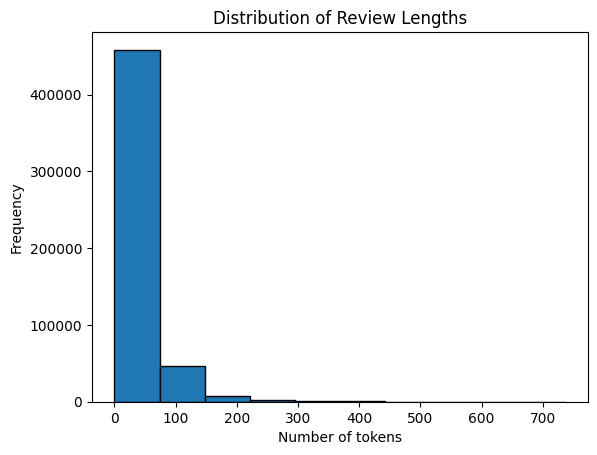

Max review length: 737
Min review length: 0
Average review length: 36.31590846515091
95th percentile of review length: 106.0


Amount of unique words: 84122
MAX_VOCAB for 97.5% coverage: 5018 words


In [22]:
# This cell is used for finding values for MAX_VOCAB and MAX_LEN

df = data.copy()

review_lengths = df["Review_Total_Negative_Word_Counts"] + df["Review_Total_Positive_Word_Counts"]

reviews = df["Negative_Review"] + df["Positive_Review"]

# tokenize the reviews and create a list of all words
all_words = [word for review in reviews for word in review.lower().split()]

# count the frequency of each word
word_counts = Counter(all_words)

# cumulative sum of word frequencies
sorted_word_counts = sorted(word_counts.values(), reverse=True)
cumulative_sum = np.cumsum(sorted_word_counts)
total_words = sum(sorted_word_counts)

# Find unique words by converting the list of tokens to a set
unique_words = set(all_words)


# plot the distribution of review lengths (number of tokens)
plt.hist(review_lengths, bins=10, edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.show()

# printing relevant information
print(f"Max review length: {max(review_lengths)}")
print(f"Min review length: {min(review_lengths)}")
print(f"Average review length: {np.mean(review_lengths)}")
print(f"95th percentile of review length: {np.percentile(review_lengths, 95)}")
print("\n")
print(f"Amount of unique words: {len(unique_words)}")

# finding ideal MAX_VOCAB (made with ChatGPT)

desired_coverage = 97.5

for max_vocab in range(1, len(cumulative_sum) + 1):

    coverage = cumulative_sum[max_vocab - 1]  
    coverage_percentage = (coverage / total_words) * 100
    
    if coverage_percentage >= desired_coverage:
        print(f"MAX_VOCAB for {desired_coverage}% coverage: {max_vocab} words")
        break 

#### Data preprocessing

In [24]:
stop_words = set(stopwords.words('english'))

data_lstm = data.copy()

# binary variable to determine sentiment
data_lstm['positive'] = (data_lstm['Reviewer_Score'] >= 5).astype(int)

# text preprocessing
MAX_VOCAB = 5018 # 97.5% coverage
MAX_LEN = 106 # 95th percentile of tokens in review

data_lstm['Positive_Review'] = data_lstm['Positive_Review'].astype(str)
data_lstm['Negative_Review'] = data_lstm['Negative_Review'].astype(str)

# this function was made by ChatGPT
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

data_lstm['Positive_Review'] = data_lstm['Positive_Review'].apply(remove_stopwords)
data_lstm['Negative_Review'] = data_lstm['Negative_Review'].apply(remove_stopwords)

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(data_lstm['Positive_Review'] + data_lstm['Negative_Review'])

# text to sequences
X_pos = tok.texts_to_sequences(data_lstm['Positive_Review'])
X_neg = tok.texts_to_sequences(data_lstm['Negative_Review'])

# pad sequences
X_pos = pad_sequences(X_pos, maxlen=MAX_LEN, padding='post', truncating='post')
X_neg = pad_sequences(X_neg, maxlen=MAX_LEN, padding='post', truncating='post')

# numerical variables
num_variables = ['Average_Score', 'Review_Total_Negative_Word_Counts',
                'Review_Total_Positive_Word_Counts']
scaler = StandardScaler()
X_num = scaler.fit_transform(data_lstm[num_variables])

tags = ['Tag_0', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5']

for tag in tags:
    label_encoded_tags = LabelEncoder()
    data_lstm[tag] = label_encoded_tags.fit_transform(data_lstm[tag])

X_tags = data_lstm[tags].values

# combine features
X = np.hstack((X_pos, X_neg, X_num, X_tags))
y = data_lstm['positive'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify = y because of high level of imbalance in positive and negative reviews

#### Building the model
In the following cell, we build the model.

First LSTM layer: 64 neurons,
Second LSTM layer: 32 neurons
Dense layer: 32 neurons in fully connected layer
Dropout layer: Randomly drop 20% of inputs during training. Low dropout level, as overfitting is near 0.
Output layer
Includes performance metrics accuracy and AUC

In [ ]:
# Build the LSTM model
model = Sequential([
    Embedding(MAX_VOCAB, 128, input_length=X_train.shape[1]),
    LSTM(64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.2), # low dropout as overfitting is near 0 anyway
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

#### Class weights
Class weights are used here to deal with the imbalanced target variable. By using class weights, the model punishes false positives more than false negatives, so that the model tries to correctly labeling the reviews, instead of labeling almost all of them as positive.

#### Calculating class weights
Using the compute_class_weight function from sklearn to calculate ideal class weight.

In [26]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)

class_weights_dict = dict(zip([0, 1], class_weights))

print(class_weights_dict)

{0: np.float64(11.573352033660589), 1: np.float64(0.522576722860436)}


In [27]:
# Train model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights_dict)

Epoch 1/5
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 589s 91ms/step - AUC: 0.7542 - accuracy: 0.7655 - loss: 0.5665 - val_AUC: 0.9200 - val_accuracy: 0.8353 - val_loss: 0.3790
Epoch 2/5
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 581s 90ms/step - AUC: 0.9197 - accuracy: 0.8501 - loss: 0.3550 - val_AUC: 0.9296 - val_accuracy: 0.8537 - val_loss: 0.3188
Epoch 3/5
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 964s 149ms/step - AUC: 0.9367 - accuracy: 0.8615 - loss: 0.3173 - val_AUC: 0.9349 - val_accuracy: 0.8558 - val_loss: 0.2987
Epoch 4/5
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 594s 92ms/step - AUC: 0.9459 - accuracy: 0.8711 - loss: 0.2926 - val_AUC: 0.9385 - val_accuracy: 0.8352 - val_loss: 0.3528
Epoch 5/5
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 598s 93ms/step - AUC: 0.9554 - accuracy: 0.8831 - loss: 0.2609 - val_AUC: 0.9431 - val_accuracy: 0.8995 - val_loss: 0.2550


#### Results
First we want to see the distribution of the predictions

3224/3224 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step


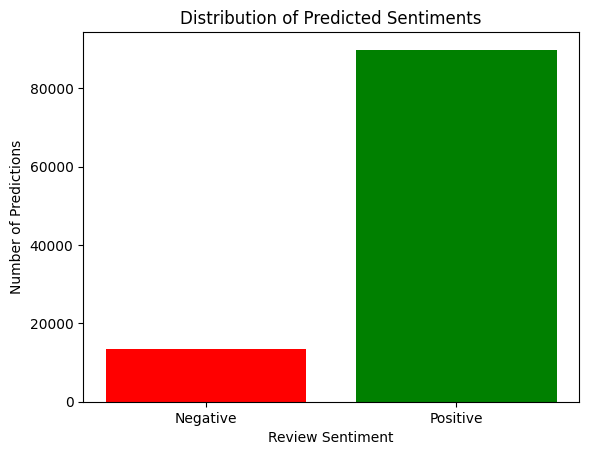

[np.int64(13358), np.int64(89790)]


In [ ]:
# Used for plotting the amount of positive and negative reviews predicted by the model

# get probabilies
y_pred_probs = model.predict(X_test)

# probabilities to binary labels
y_pred = (y_pred_probs >= 0.5).astype(int)

positive_count = np.sum(y_pred == 1)
negative_count = np.sum(y_pred == 0)

categories = ['Negative', 'Positive']
counts = [negative_count, positive_count]

plt.bar(categories, counts, color=['red', 'green'])
plt.xlabel("Review Sentiment")
plt.ylabel("Number of Predictions")
plt.title("Distribution of Predicted Sentiments")

plt.show()
print(counts)

Based on the results from the KNN model we know that without class weights, the model predicted that nearly all reviews were positive, resulting in high accuracy scores, but this is not what we want.

After including class weights, we can see that there are more reviews being labled as negative than what we found in our data analysis. This is expected, as the model punishes false positives more than false negatives.

#### Evaluating the model
The following cell is for evaluating the model

The most relevant metrics are accuracy, F1 score and ROC-AUC.

F1 score is relevant we want a good balance of false positives and false negatives.
ROC-AUC score is relevant as it works well with high imbalances. The score being near 1 also indicates that the model works well across all thresholds.

We also look at precision and recall to see how the imbalance is affecting the results.

In [29]:
# This cell is for evaluating the model

test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
train_loss, train_accuracy, train_auc = model.evaluate(X_train, y_train)
print(f'Test accuracy: {test_accuracy:.2f}')
print(f'Train accuracy: {train_accuracy:.2f}')
print(f'Overfitting: {train_accuracy-test_accuracy:.2f}')

# Convert predicted probabilities to binary classification (positive or negative review)
y_pred_prob = model.predict(X_test)  
y_pred = (y_pred_prob >= 0.5).astype(int)  # 1 if probability >= 5, otherwise 0

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob) 

# Results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}') # How many predicted positives are actually positive
print(f'Recall: {recall:.2f}') # How many actual positive cases were correctly predicted
print(f'F1-Score: {f1:.2f}') # Harmonic mean of precision and recall
print(f'ROC-AUC: {roc_auc:.2f}') # Area under ROC curve (recall against false positive rate)

# Scores from 0-1, where higher scores = better performance

3224/3224 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - AUC: 0.9454 - accuracy: 0.9003 - loss: 0.2543
12894/12894 ━━━━━━━━━━━━━━━━━━━━ 296s 23ms/step - AUC: 0.9616 - accuracy: 0.9097 - loss: 0.2364
Test accuracy: 0.90
Train accuracy: 0.91
Overfitting: 0.01
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step
Accuracy: 0.90
Precision: 0.99
Recall: 0.90
F1-Score: 0.94
ROC-AUC: 0.94


The precision being near 1 means that nearly all predicted positives are actually positive. The class weights make it so that the model will rarely label any negative reviews as positive. This might be affecting the accuracy of the model. The class weights could be adjusted to decrease the gap between precision and recall. However, we believe that a precision score close to 1 is preferred, because hotels would likely be more interested in the negative reviews. Therefore we don't want the model to mislabel negative reviews as positive.

### Model 4 TF-IDF
The fourth and final model is based on feature extraction using the TF-IDF metric and modelling with logistic regression.

#### TF-IDF
*Term frequency-inverse document frequency* is a measure of how unique a term is to a document in a corpus. This is calculated by finding the product of two measures, namely term frequency and inverse document frequency.

Term frequency is the number of times a term $t$ appears in a document $d$ divided by the total number of terms (including repeated terms). This can be denoted by the following function:

$$tf(t,d)=\frac{f_{t,d}}{\sum_{t'\in d} f_{t',d}}$$

As an example we look at the following 'document': *"To be or not to be, that is the question."* We call that document $d$. Using the function above we find the following frequencies:

$$tf(\mathrm{"be"}, d)=\frac{2}{10}=0.2$$
$$tf(\mathrm{"is"}, d)=\frac{1}{10}=0.1$$
$$tf(\mathrm{"question"}, d)=\frac{1}{10}=0.1$$

From these results one could conclude that the words "is" and "question" bear the same importance in the document. Most would however say that "question" is a more defining word as it is more unique. This is where inverse term frequency comes in.

Inverse term frequency takes in to account the entire corpus $D$. It counts the number of documents in the corpus and divides it by the number of documents which contain the term $t$ and then takes the logarithm. This is denoted by the following function:

$$idf(t,D)=\log{\frac{|D|}{|\{d:d\in D \,\wedge \,t\in d\}|}}$$

This leads to less common terms getting a higher $idf$. This lets us calculate the TF-IDF metric of a term $t$ in a document $d$ of a corpus $D$:

$$tfidf(t,d,D)=tf(t,d)\cdot idf(t,D)$$

To set the dataset up for TF-IDF we do the following:

In [5]:
tfidf_data = data.copy() # Take a copy of the data

reviews = tfidf_data["Negative_Review"] # Extract the negative reviews.

tfidf_vectorizer = TfidfVectorizer(stop_words="english") # Set up the vectorizer class
# NOTE: stop_words filters out common short words in english, e.g 'is, 'the', etc.

X = tfidf_vectorizer.fit_transform(reviews) # Vectorize all reviews and assign as input variable.
y = data["Reviewer_Score"].map(lambda x: 0 if x < 5.0 else 1) # Generate correpsponding output.

# print(X.get_feature_names_out())
# print(X.head())

The *TfidfVectorizer* creates a set of all words contained in all of the reviews. It then calculates a TF-IDF score for each unique word for each document in the corpus. This should allow us to create a model which can correlate the combination of frequencies of certain words to either a good or bad sentiment. 

As the result can either be 'good' or 'bad', we could assign a probability to each of them which add up to 100%. A model based on logistic regresison would correspond to this scenario. We set it up using the built in class from Scikit.

In [6]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up class weights. See previous explanation.
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weights_dict = dict(zip([0, 1], class_weights))

# Set up Logistic Regression model.
model = LogisticRegression(class_weight=class_weights_dict, max_iter=1000)

# Fit data to model
model.fit(X_train, y_train)


LogisticRegression(class_weight={0: np.float64(11.60068604847326),
                                 1: np.float64(0.5225211305777253)},
                   max_iter=1000)

The model has now been trained on 80% of the data. Lets now make a prediction of *y_test* and evaluate the model using a variety of metrics.

In [8]:
# Convert predicted probabilities to binary classification
y_pred = model.predict(X_test)  

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred) 

# Results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}') # How many predicted positives are actually positive
print(f'Recall: {recall:.2f}') # How many actual positive cases were correctly predicted
print(f'F1-Score: {f1:.2f}') # Balance betweet precision and recall
print(f'ROC-AUC: {roc_auc:.2f}') # Area under ROC curve (recall against false positive rate)


Accuracy: 0.84
Precision: 0.99
Recall: 0.84
F1-Score: 0.91
ROC-AUC: 0.80


These are promising metrics. They show that the model is able to accurately label sentiment. The ROC-AUC score is lower than in the LSTM model, but this is no surprise as we would expect the LSTM model to be better at capturing underlying patterns.

## Task 2
This code was written while using github Copilot.

In [38]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [39]:
# Checking the shape of the data
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [40]:
# Here are the classes from the CIFAR-10 dataset. Dog is index 5.
# Information about the classes can be found at https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

In [41]:
# Change the answer data to check if the answer is a dog or not
def dogify(y):
    for i in range(len(y)):
        if y[i] == 5:
            y[i] = 1
        else:
            y[i] = 0
    return y

In [42]:
dogify(y_train)
dogify(y_test)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=uint8)

In [43]:
# Figuring out the max value of the pixel values in the dataset
print("Max pixel value:", np.max(x_train))
print("Min pixel value:", np.min(x_train))

Max pixel value: 255
Min pixel value: 0


In [44]:
# Normalizing the pixel values to be between 0 and 1
x_train = x_train/255
x_test = x_test/255

The CNN-model have several layers.
The input layer indicates the shape of the input. In this case pictures with 32x32 pixels with rbg-values.
The convonutional layer creates filters that is supposed to classify features. In this case the first convonutional
layer creates 32 filters for each 3x3 square, while the next 2 create 64 filters for each square. 
The stride length is 1 by default. The pooling layer looks at every value in a 2x2 square an 
gives the highest value. Here the stride length is 2, as the default is the same as the pooling value. 
The flatteneing layer changes the data to be 1 dimensional for the fully connected layers at the end.
The first layer have 64 neurons connected to the 2 neurons at the end.

The logic for adding more filters in the later convonutional layers are that the features detected in the later part of the model are more complex, while in the earlier part its easier features like edges or colour changes. 

In [45]:
# Creating the CNN model
model= models.Sequential([
    Input(shape=(32, 32, 3)), # Input layer, shape found earlier
    layers.Conv2D(32, (3, 3), activation='relu'), # First convolutional layer
    layers.MaxPooling2D((2, 2)), # First pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'), # Second convolutional layer
    layers.MaxPooling2D((2, 2)), # Second pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'), # Third convolutional layer
    layers.Flatten(), # Flattening the data to feed into the dense layer
    layers.Dense(64, activation='relu'), # Dense layer with 64 neurons
    layers.Dense(2, activation='sigmoid') # Output layer with 2 neurons (dog or not dog)
])

This dataset is inbalanced. It has equal number of pictures of each category, but dog is only one of 10 the categories. This means that only one tenth of the pictures are of dogs.

In [46]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train.flatten())
class_weights_dict = dict(zip([0, 1], class_weights))
print(class_weights_dict)

{0: np.float64(0.5555555555555556), 1: np.float64(5.0)}


In [47]:
model.compile(optimizer='adam',  
              loss='sparse_categorical_crossentropy', # This loss function worked better than 'binary_crossentropy'.
              metrics=['accuracy'])

# Train the model with class weights
training = model.fit(x_train, y_train, epochs=10,
           validation_data=(x_test, y_test),
           class_weight=class_weights_dict)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6107 - loss: 0.5834 - val_accuracy: 0.7956 - val_loss: 0.4190
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7777 - loss: 0.4458 - val_accuracy: 0.8676 - val_loss: 0.3041
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7949 - loss: 0.4085 - val_accuracy: 0.8020 - val_loss: 0.4210
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8106 - loss: 0.3808 - val_accuracy: 0.7762 - val_loss: 0.4531
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8266 - loss: 0.3512 - val_accuracy: 0.8585 - val_loss: 0.3174
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8455 - loss: 0.3227 - val_accuracy: 0.8125 - val_loss: 0.4071
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8481 - loss: 0.3021 - val_accuracy: 0.8424 - val_loss: 0.3333
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8671 - loss: 0.2689 -

I used activation sigmoid with sparse_categorical_crossentropy as this is the combination that worked best during 
my testing. It is unclear as to why this proved to be the best combination. I tested several combination with softmax, sigmoid, sparse_categorical_crossentropy, binary_crossentropy, 1 neuron in the final layer and 2 neurons in the final layer.

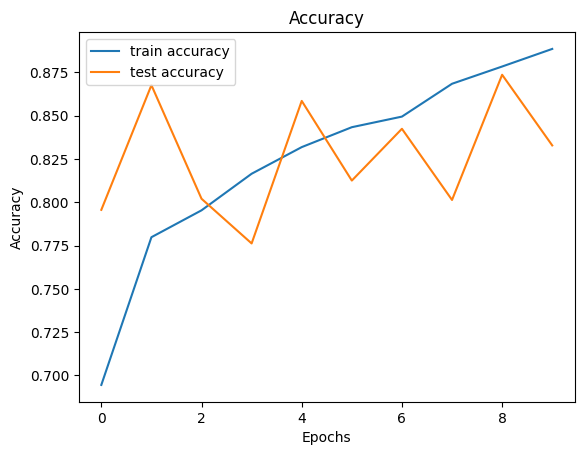

In [48]:
# Plotting the training and validation accuracy and loss
plt.plot(training.history['accuracy'], label='train accuracy')
plt.plot(training.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The flattenning of the train accuracy curve shows that 10 epochs is enough for this model

In [49]:
# Predicting the test set
y_pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [50]:
# Creating a confusion matrix
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[7498 1502]
 [ 170  830]]


In [51]:
#Checking if the model can correctly identify a dog
def check_if_dog(file):
    dog=Image.open(file)
    plt.imshow(dog)
    dog = dog.convert("RGB")
    dog = dog.resize((32, 32))
    dog = np.array(dog)
    dog = dog/255
    dog = np.expand_dims(dog, axis=0)
    dog_pred = model.predict(dog)
    print("Is dog?", np.argmax(dog_pred, axis=1)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Is dog? 1


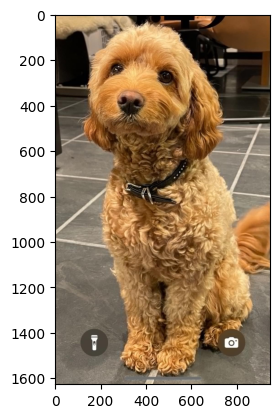

In [52]:
check_if_dog("Dog1.jpg")